In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
from PIL import Image
from HandwrittenAnnotation import random_augment,center_to_corner_box, corner_to_center_box
from HandwrittenAnnotation import get_anchors, extraction_boxes, show_image_labels
# from etl import decode_label
import etl

In [5]:
# 全データの読み込み
etl_path = '/Users/chai/data/etlcdb/numpy/etl9b/'
images, boxes, labels = etl.get_annotation_data(etl_path)

In [7]:
from HandwrittenAnnotation import YOLO
log_dir = 'model_weight/'
model_name = 'weights4.h5'
anchors_path = 'model_data/yolo_anchors.txt'
num_classes = 3036

import random
# input_shape = np.array([image_size[0]*1.5, image_size[1]*(num_concat)], dtype=np.int64)
input_shape = np.array([96, 320], dtype=np.int64)

yolo = YOLO(log_dir + model_name, anchors_path, np.arange(num_classes), input_shape, num_channels=1)

In [8]:
# サンプルの生成
image_size = [64, 64]
num_concat = 4

idx = [random.randrange(num_classes * 200) for _ in range(num_concat)]
r_translate = 0
r_scale = 0
r_aspect_rate = 0
image_input_shape = np.array([image_size[0]*1.5, image_size[1]*(num_concat)], dtype=np.int64)

image, _ = random_augment(idx, images, boxes, image_size, image_input_shape,
                          r_translate, r_scale, r_aspect_rate, np.bool)
pil_img = Image.fromarray(np.uint8(image))

In [9]:
# 画像の読み込み
img_dir = 'test_img/'
file_name = 'test6.png'
pil_img = Image.open(img_dir + file_name)
pil_img = pil_img.convert('L')

def g2b_image(img):
    np_img = np.array(img)
    average = np.average(np_img)
    print(average)
    np_img = np.where(np_img > average, 0, 1)
    print(np_img.dtype)
    return  Image.fromarray(np.uint8(np_img))

pil_img = g2b_image(pil_img)

232.69489539748955
int64


In [10]:
print(pil_img.size)
o_image, o_box, o_score, o_class = yolo.detect_image(pil_img, image_mode='L')
o_image = np.squeeze(o_image)

o_box = o_box.astype(np.float32)
if len(o_box) != 0:
    o_box[:, 0:2] = np.array([box[0:2] / o_image.shape[::-1] for box in o_box])
    o_box[:, 2:4] =np.array([box[2:4] / o_image.shape[::-1] for box in o_box])

o_box = list(map(corner_to_center_box, o_box))
list(map(print, o_box))
list(map(print, o_score))

(239, 50)
Found 3 boxes for img
2825 0.11 (270, 22) (319, 70)
67 0.31 (271, 7) (318, 86)
1416 0.90 (0, 21) (62, 72)
55.64845624000009
[0.92031249 0.47916667 0.15312499 0.5       ]
[0.92031249 0.48437498 0.14687496 0.82291663]
[0.096875   0.484375   0.19374999 0.53125   ]
0.902863
0.30828884
0.11284945


[None, None, None]

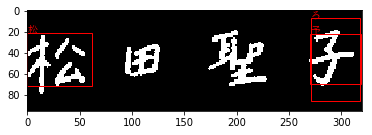

In [11]:
show_image_labels(np.array(o_image), o_box, o_score, map(etl.decode_label, reversed(o_class)), threshould=0)

In [12]:
idx = np.argsort(np.array(o_box)[:, 0])
print(list(map(etl.decode_label, o_class[::-1][idx])))
print(o_score[::-1][idx])

['松', '予', 'ろ']
[0.902863   0.11284945 0.30828884]


In [13]:
# 全体にバリエーションを増やす